# Unsupervised anomaly detection in the MNIST dataset using simple Autoencoders

The goal here is to generate some simple anomalies in the MNIST dataset and design an autoencoder (AE) which is capable of detecting and segmenting the errors introduced in the digits images.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies, plot_predictions

print(tf.__version__)

2.2.0


### Dataset

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Utility functions to generate and plot anomalies

Text(0.5, 1.0, 'square anomaly')

<Figure size 432x288 with 0 Axes>

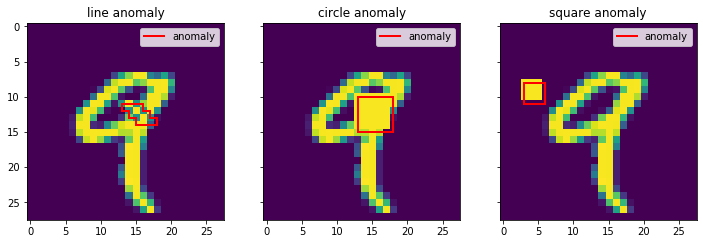

In [3]:
plt.viridis()

idx = 4

norm = x_train[idx].reshape((28, 28))

anoml = set_anomaly(norm, an_type="l", an_size=3, s=0)
anomc = set_anomaly(norm, an_type="c", an_size=3, s=0)
anoms = set_anomaly(norm, an_type="s", an_size=5, s=10)

maskimgl = np.abs(anoml - norm) > 0
maskimgc = np.abs(anomc - norm) > 0
maskimgs = np.abs(anoms - norm) > 0

fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharey="all", sharex="all")

axes[0].imshow(anoml)
contour_anomalies(axes[0], maskimgl)
axes[0].set_title("line anomaly")
axes[1].imshow(anomc)
contour_anomalies(axes[1], maskimgc)
axes[1].set_title("circle anomaly")
axes[2].imshow(anoms)
contour_anomalies(axes[2], maskimgs)
axes[2].set_title("square anomaly")

# 1. The simple autoencoder

In [4]:
from uad.models.autoencoder import Dense_AE

input_shape = 784
hidden_shape = 64
latent_dim = 32

autoencoder = Dense_AE(input_shape, hidden_shape, latent_dim)

In [5]:
autoencoder.model.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.model.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1577
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1121
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1037


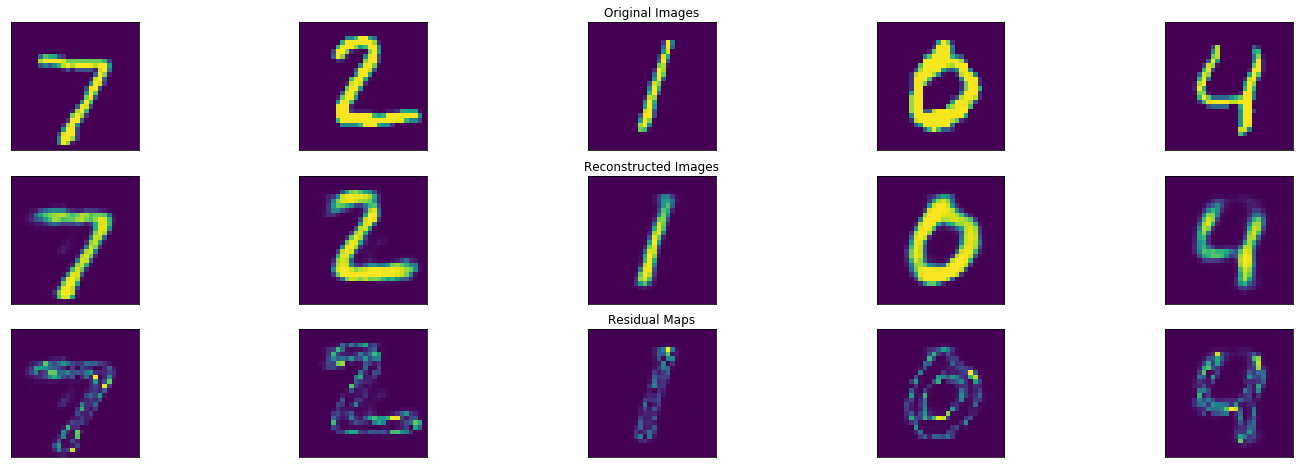

In [6]:
plot_predictions(autoencoder.model, x_test, 5, dims=(784,))

In [7]:
pred, anomalies, anomalies_pred = predict_anomalies(autoencoder.model, x_test, dims=(784,))

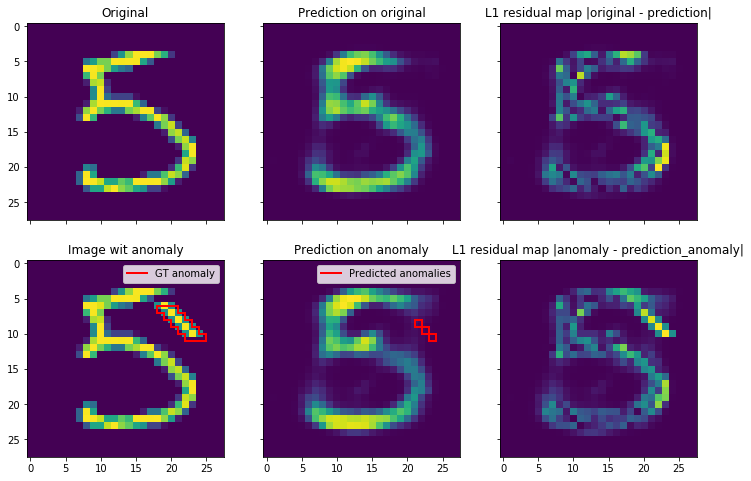

In [9]:
plot_anomalies(x_test, pred, anomalies, anomalies_pred, show_idx=15, threshold=0.9, ref_dims=(784,))

Thus we show that with a simple encoder architecture, we are able to detect and segment anomalies on new examples, to some extent. The threshold has to be chosen according to a trade-off between getting all the anormal pixels (even those with low intensity) and getting a lot of false positives. Next, we wille check with an autoencoder architecture if we can improve the performances.

# 2. Convolutional Autoencoder

Here we adapt the UNet architecture to our problem : we suppress the skip connections and keep the convolutional encoder-decoder structure.

To begin we use a reduced UNet architecture, with only two convolution-pooling blocks of two layers in the coder and in the encoder, instead of for blocks for each in the original architecture. The number of filters was also reduced by 16.

In [23]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, -1).astype('float32') / 255.0
    
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [24]:
from uad.models.autoencoder import SimpleConvAE

input_shape = (28, 28, 1)
n_filters = 4
batchnorm = False
dropout = 0.2
  
cae = SimpleConvAE(input_shape, n_filters, batchnorm, dropout)

In [25]:
cae.model.compile(optimizer='adam', loss='binary_crossentropy')

cae.model.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 76s 41ms/step - loss: 0.2031
Epoch 2/3
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1344
Epoch 3/3
1875/1875 [==============================] - 76s 41ms/step - loss: 0.1230


In [28]:
pred, anomalies, anomalies_pred = predict_anomalies(cae.model, x_test, dims=(28, 28, 1))

(10000, 28, 28)


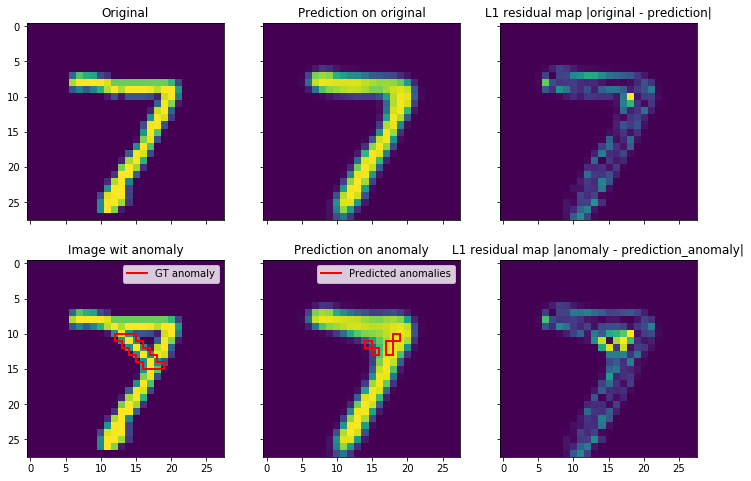

In [29]:
x_test1 = np.squeeze(x_test, axis=-1)
plot_anomalies(x_test1, pred, anomalies, anomalies_pred, show_idx=0, threshold=0.7, ref_dims=(28, 28))

We see that the convolutional autoencoder outperforms the standard one, with a better segmentation of the identified anomaly (at constant threshold).